In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import time
from datetime import timedelta
from scipy import misc
import imageio
%matplotlib inline

# Load data

In [2]:
def load_data(PATH):
    
    def load_images(filenames):
        images = np.array([imageio.imread(filename) for filename in filenames])
        # print(images.shape)
        return images 

    default_dir = os.getcwd()
    os.chdir(PATH)

    main_dir = os.getcwd()

    sets = os.listdir()
    
    os.chdir(sets[0])

    classes = os.listdir()

    train_dir = os.getcwd()
   


    train_X = [] 
    train_Y = [] 

     
    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()
        
        
        train_X.append(load_images(filenames)) 
        train_Y.append(np.full((train_X[-1].shape[0], 1), i))
        os.chdir(train_dir)
        
    os.chdir(main_dir)
    os.chdir(sets[1]) 
    test_dir = os.getcwd()

    test_X = []
    test_Y = []

    for i in range(len(classes)):
        os.chdir(classes[i])
        filenames = os.listdir()        
        test_X.append(load_images(filenames)) 
        test_Y.append(np.full((test_X[-1].shape[0], 1), i))
        os.chdir(test_dir)
    
   # print(train_X))
    train_X = np.concatenate((train_X[0], train_X[1]), axis=0)
    train_Y = np.concatenate((train_Y), axis=0)
    

    test_X = np.concatenate((test_X[0], test_X[1]), axis=0)
    test_Y = np.concatenate((test_Y), axis=0)

    index = 43
    plt.imshow(test_X[index], cmap='gray')
    plt.title(test_Y[index])
    plt.show()

    os.chdir(default_dir)
    
    return train_X, train_Y, test_X, test_Y 


In [6]:
PATH = 'data2/'

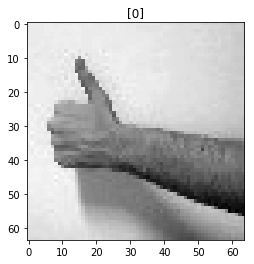

In [7]:
train_X, train_Y_class, test_X, test_Y_class = load_data(PATH)

In [8]:
img_size = 64

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 2

In [9]:
def plot_images(images, true_class, pred_class=None):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_size, img_size), cmap='gray')
        
        if pred_class is None:
            xlabel = f"True: {true_class[i]}"
        else:
            xlabel = f"True: {true_class[i]}, Pred: {pred_class[i]}"
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()    

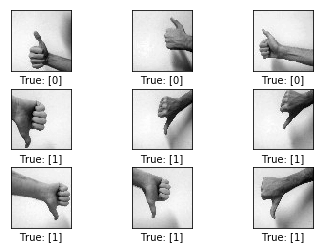

In [10]:
index = 1255

images = train_X[index:index+10]

true_class = train_Y_class[index:index+10]

plot_images(images=images, true_class=true_class)

## Data preprocessing

In [11]:
def preprocess_images(X):
    X = (X / 255 * 0.99) + 0.01
    return np.float32(X).reshape(-1, img_size, img_size, num_channels)

def one_hot(nums):
    output = np.eye(num_classes)[nums]
    return np.squeeze(output)

In [12]:
train_X = preprocess_images(train_X)
test_X = preprocess_images(test_X)

train_Y = one_hot(train_Y_class)
test_Y = one_hot(test_Y_class)


print(f"Number of train examples: {train_X.shape[0]}")
print(f"Number of test examples: {test_X.shape[0]}")
print(f"Train images shape: {train_X.shape}")
print(f"Test images shape: {test_X.shape}")
print(f"Train Labels shape: {train_Y.shape}")
print(f"Test Labels shape: {test_Y.shape}")

Number of train examples: 2143
Number of test examples: 200
Train images shape: (2143, 64, 64, 1)
Test images shape: (200, 64, 64, 1)
Train Labels shape: (2143, 2)
Test Labels shape: (200, 2)


# Model

## Conv net hyper parameters

In [18]:
filter_size1 = 3
num_filters1 = 8

filter_size2 = 3
num_filters2 = 16

# filter_size3 = 3
# num_filters3 = 128

# filter_size4 = 3
# num_filters4 = 128

fc_layer = 128

lr=0.001

## Conv layer

In [19]:
def create_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    
    filter_shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    print(filter_shape)
    
    weights = tf.Variable(tf.truncated_normal(shape=filter_shape))
    
    biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
    
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                         padding='SAME')
    
    layer += biases
    
    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        
    layer = tf.nn.relu(layer)
    
    return layer, weights

## FC layer

In [20]:
def create_fully_connected(input,
                          num_inputs,
                          num_outputs,
                          use_relu=True):
    
    weights = tf.Variable(tf.truncated_normal(shape=[num_inputs, num_outputs]))
    
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## Flatten conv layer

In [21]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

## Placeholders

In [22]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y = tf.placeholder(tf.float32, shape=[None, num_classes], name='y')

## Conv 1

In [23]:
layer_conv1, weights_conv1 = create_conv_layer(input=x,
                                              num_input_channels=num_channels,
                                              filter_size=filter_size1,
                                              num_filters=num_filters1,
                                              use_pooling=True)

[3, 3, 1, 8]


In [24]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 8) dtype=float32>

## Conv 2

In [17]:
# layer_conv2, weights_conv2 = create_conv_layer(input=layer_conv1,
#                                               num_input_channels=num_filters1,
#                                               filter_size=filter_size2,
#                                               num_filters=num_filters2,
#                                               use_pooling=True)

[3, 3, 8, 16]


In [25]:
# layer_conv2

## Conv 3

In [26]:
# layer_conv3, weights_conv3 = create_conv_layer(input=layer_conv2,
#                                               num_input_channels=num_filters2,
#                                               filter_size=filter_size3,
#                                               num_filters=num_filters3,
#                                               use_pooling=True)

In [27]:
# layer_conv3

## Conv 4

In [28]:
# layer_conv4, weights_conv4 = create_conv_layer(input=layer_conv3,
#                                               num_input_channels=num_filters3,
#                                               filter_size=filter_size4,
#                                               num_filters=num_filters4,
#                                               use_pooling=True)

In [29]:
# layer_conv4

## FC1

In [31]:
layer_flat, num_features = flatten_layer(layer_conv1)
print(f"Num features: {num_features}")

Num features: 8192


In [32]:
fc_layer1 = create_fully_connected(input=layer_flat,
                                  num_inputs=num_features,
                                  num_outputs=fc_layer,
                                  use_relu=True)

In [33]:
fc_layer1

<tf.Tensor 'Relu_1:0' shape=(?, 128) dtype=float32>

In [34]:
fc_layer2 = create_fully_connected(input=fc_layer1,
                                  num_inputs=fc_layer,
                                  num_outputs=num_classes,
                                  use_relu=False)

In [35]:
fc_layer2

<tf.Tensor 'add_2:0' shape=(?, 2) dtype=float32>

## Softmax

In [36]:
y_pred = tf.nn.softmax(fc_layer2)
y_pred_class = tf.argmax(y_pred, axis=1)

In [37]:
y_pred_class

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [38]:
train_Y_class.reshape(-1).shape

(2143,)

## Cost

In [39]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=fc_layer2, labels=y)

In [40]:
cost = tf.reduce_mean(cross_entropy)

## Optimizer

In [41]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

## Accuracy

In [42]:
correct_predictions = tf.equal(y_pred_class, train_Y_class.reshape(-1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

## Saver

In [66]:
saver = tf.train.Saver()

In [67]:
save_dir = 'checkpoints/3_simpler/'

## Running Tensorflow session

In [43]:
session = tf.Session()

In [44]:
session.run(tf.global_variables_initializer())

## Minibatch helper function

In [45]:
batch_size = 64

In [46]:
def split_into_batches(X, Y):
    full_sized = math.floor(X.shape[0] / batch_size)
    print(f"Full sized: {full_sized}")
    batches_X = []
    batches_Y = []
    
    for i in range(full_sized):
        batches_X.append(X[i*batch_size:(i+1) * batch_size])
        batches_Y.append(Y[i*batch_size:(i+1) * batch_size])
        
        
    last_elems = full_sized * batch_size - X.shape[0]
    if last_elems != 0:
        print(f"kasel")
        batches_X.append(X[last_elems:])
        batches_Y.append(Y[last_elems:])
        
    return batches_X, batches_Y
    
    

In [47]:
%%time
print("kasel")

kasel
CPU times: user 109 µs, sys: 11 µs, total: 120 µs
Wall time: 85.1 µs


In [48]:
total_epochs = 0
def optimize(num_epochs):
     
    global total_epochs
    start_time = time.time()
    
    for i in range(total_epochs, total_epochs + num_epochs):
        
        for x_batch, y_batch in zip(X_batches, Y_batches):
            
            feed_dict_train = {x: x_batch,
                              y: y_batch}
            
#             print(feed_dict_train[x].shape)
#             print(feed_dict_train[y].shape)
            
            session.run(optimizer, feed_dict=feed_dict_train)
#             print(":)")
        
        feed_dict_train_acc = {x: train_X, y: train_Y}
        acc = session.run(accuracy, feed_dict=feed_dict_train_acc)
    
        print(f"Epoch {i}: Train_acc: {str(acc*100)[:5]}%")
        
    total_epochs += num_epochs
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    
    print(f"Time usage: {timedelta(seconds=int(round(time_dif)))}")

In [49]:
def print_accuracy(X, Y):
    feed_dict_test = {x: X,
                     y: Y}
    
#     print(feed_dict_test[x].shape)
#     print(feed_dict_test[y].shape)
    
    pred_class = session.run(y_pred_class, feed_dict=feed_dict_test)
    
#     print(pred_class.shape)
    
    true_class = np.argmax(Y, axis=1)
#     print(str(pred_class.shape) + "||" + str(true_class.shape))
    pred_class = np.array(pred_class)
    correct = (pred_class == true_class)
    
#     print(correct)
    correct_sum = correct.sum()
    
    acc = float(correct_sum) / len(correct)
    
    return acc
    print(f"Test accuracy: {str(acc * 100)[:5]}%")

# Training

In [50]:
X_batches, Y_batches = split_into_batches(train_X, train_Y)

Full sized: 33
kasel


In [51]:
print(test_X.shape)

(200, 64, 64, 1)


In [52]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 50.0%
Train accuracy: 41.29%


In [53]:
optimize(num_epochs=1)

Epoch 0: Train_acc: 41.29%
Time usage: 0:00:06


In [54]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 50.0%
Train accuracy: 41.29%


In [55]:
optimize(num_epochs=5)

Epoch 1: Train_acc: 41.29%
Epoch 2: Train_acc: 41.29%
Epoch 3: Train_acc: 41.29%
Epoch 4: Train_acc: 41.29%
Epoch 5: Train_acc: 41.29%
Time usage: 0:00:25


In [56]:
# saver.save(sess=session, save_path=save_dir)

In [57]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 50.0%
Train accuracy: 41.29%


In [58]:
optimize(num_epochs=5)

Epoch 6: Train_acc: 41.29%
Epoch 7: Train_acc: 51.37%
Epoch 8: Train_acc: 92.53%
Epoch 9: Train_acc: 97.85%
Epoch 10: Train_acc: 97.85%
Time usage: 0:00:24


In [59]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 98.5%
Train accuracy: 97.85%


In [60]:
optimize(num_epochs=5)

Epoch 11: Train_acc: 97.99%
Epoch 12: Train_acc: 98.08%
Epoch 13: Train_acc: 98.27%
Epoch 14: Train_acc: 98.22%
Epoch 15: Train_acc: 98.32%
Time usage: 0:00:24


In [61]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 98.5%
Train accuracy: 98.32%


In [62]:
optimize(num_epochs=10)

Epoch 16: Train_acc: 98.36%
Epoch 17: Train_acc: 98.46%
Epoch 18: Train_acc: 98.50%
Epoch 19: Train_acc: 98.55%
Epoch 20: Train_acc: 98.55%
Epoch 21: Train_acc: 98.60%
Epoch 22: Train_acc: 98.60%
Epoch 23: Train_acc: 98.74%
Epoch 24: Train_acc: 98.69%
Epoch 25: Train_acc: 98.97%
Time usage: 0:00:50


In [57]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 98.5%
Train accuracy: 99.20%


In [58]:
optimize(num_epochs=10)

Epoch 26: Train_acc: 99.34%
Epoch 27: Train_acc: 99.44%
Epoch 28: Train_acc: 99.16%
Epoch 29: Train_acc: 99.30%
Epoch 30: Train_acc: 99.48%
Epoch 31: Train_acc: 99.62%
Epoch 32: Train_acc: 99.62%
Epoch 33: Train_acc: 99.53%
Epoch 34: Train_acc: 99.58%
Epoch 35: Train_acc: 99.62%
Time usage: 0:01:36


In [59]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 99.0%
Train accuracy: 99.62%


In [63]:
optimize(num_epochs=100)

Epoch 26: Train_acc: 99.25%
Epoch 27: Train_acc: 99.25%
Epoch 28: Train_acc: 99.34%
Epoch 29: Train_acc: 99.44%
Epoch 30: Train_acc: 99.44%
Epoch 31: Train_acc: 99.53%
Epoch 32: Train_acc: 99.58%
Epoch 33: Train_acc: 99.58%
Epoch 34: Train_acc: 99.58%
Epoch 35: Train_acc: 99.58%
Epoch 36: Train_acc: 99.58%
Epoch 37: Train_acc: 99.58%
Epoch 38: Train_acc: 99.62%
Epoch 39: Train_acc: 99.67%
Epoch 40: Train_acc: 99.72%
Epoch 41: Train_acc: 99.72%
Epoch 42: Train_acc: 99.72%
Epoch 43: Train_acc: 99.72%
Epoch 44: Train_acc: 99.67%
Epoch 45: Train_acc: 99.67%
Epoch 46: Train_acc: 99.72%
Epoch 47: Train_acc: 99.72%
Epoch 48: Train_acc: 99.72%
Epoch 49: Train_acc: 99.72%
Epoch 50: Train_acc: 99.76%
Epoch 51: Train_acc: 99.76%
Epoch 52: Train_acc: 99.81%
Epoch 53: Train_acc: 99.81%
Epoch 54: Train_acc: 99.90%
Epoch 55: Train_acc: 99.86%
Epoch 56: Train_acc: 99.86%
Epoch 57: Train_acc: 99.81%
Epoch 58: Train_acc: 99.81%
Epoch 59: Train_acc: 99.86%
Epoch 60: Train_acc: 99.90%
Epoch 61: Train_acc:

KeyboardInterrupt: 

In [64]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 99.5%
Train accuracy: 100.0%


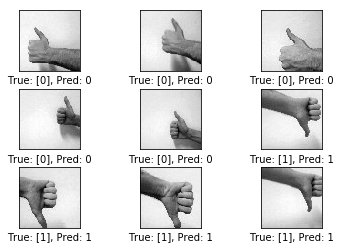

In [64]:
index = 95


images = test_X[index:index+10]

true_class = test_Y_class[index:index+10]

feed_dict_test = {x: test_X, y: test_Y}

preds = session.run(y_pred_class, feed_dict=feed_dict_test)[index:index+10]

# preds = session.run(y_pred_class, feed_dict=feed_dict_test)
# print(preds.shape)


plot_images(images=images, true_class=true_class, pred_class=preds)

In [66]:
optimize(num_epochs=10)

Epoch 36: Train_acc: 99.58%
Epoch 37: Train_acc: 99.53%
Epoch 38: Train_acc: 99.62%
Epoch 39: Train_acc: 99.67%
Epoch 40: Train_acc: 99.90%
Epoch 41: Train_acc: 99.90%
Epoch 42: Train_acc: 99.81%
Epoch 43: Train_acc: 99.90%
Epoch 44: Train_acc: 99.90%
Epoch 45: Train_acc: 99.86%
Time usage: 0:00:58


In [67]:
print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

Test accuracy: 99.0%
Train accuracy: 99.86%


In [68]:
saver.save(sess=session, save_path=save_dir)

'checkpoints/3_simpler/'

In [ ]:
# session.run(tf.global_variables_initializer())

In [ ]:
# print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
# print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")

In [ ]:
# saver.restore(sess=session, save_path=save_dir)

In [ ]:
# print(f"Test accuracy: {str(print_accuracy(test_X, test_Y) * 100)[:5]}%")
# print(f"Train accuracy: {str(print_accuracy(train_X, train_Y) * 100)[:5]}%")